In [2]:
# 忽略warnings
import warnings 
warnings.filterwarnings('ignore') 

# 导入系统库
import os

# 强制使用CPU
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

# 导入Python通用库
import matplotlib.pyplot as plt
import numpy as np

# 导入TF 2.0并设置GPU
import tensorflow as tf
# 导入Keras库
from tensorflow import keras
# 设置使用GPU显存的比例
# from keras.backend.tensorflow_backend import set_session
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.6
# tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config)) 

# 导入util模块的各种方法
# from keras.utils.np_utils import to_categorical
# 导入模型、优化器、损失函数等等
from keras.models import Sequential, Model
from keras import Input, layers
# from keras import preprocessing
# from keras import regularizers
# from keras import optimizers
# from keras import metrics
# from keras import models
# from keras import losses
# from keras import layers
# 导入Keras字符处理模块
# from keras.preprocessing.sequence import pad_sequences
# from keras.layers import Flatten, Dense, Embedding
# from keras.preprocessing.text import Tokenizer
# from keras.models import Sequential
# 导入预训练模型
# from keras.applications import VGG16
# 导入数据集
# from keras.datasets import imdb

Using TensorFlow backend.


# 07. 高级的深度学习最佳实践
本章包括以下内容：
+ `Keras`函数式API
+ 使用`Keras`回调函数
+ 使用`TensorBoard`可视化工具
+ 开发最先进模型的重要最佳实践

本章将介绍几种强大的工具，可以让你朝着针对困难问题来开发最先进模型这一目标更近一步。利用`Keras`函数式API，你可以构建类图（graph-like）模型、在不同的输入之间共享某一层，并且还可以像使用`Python`函数一样使用`Keras`模型。`Keras`回调函数和`TensorBoard`基于浏览器的可视化工具，让你可以在训练过程中监控模型。我们还会讨论其他几种最佳实践，包括`批标准化`、`残差连接`、`超参数优化`和`模型集成`。

## 7.1 不用Sequential模型的解决方案：Keras函数式API
到目前为止，本书介绍的所有神经网络都是用`Sequential`模型实现的。`Sequential`模型假设，网络只有一个输入和一个输出，而且网络是层的线性堆叠（见`图7-1`）。

<img src="images/07_01.png" style="width:300px;"/>

这是一个经过普遍验证的假设。这种网络配置非常常见，以至于本书前面只用`Sequential`模型类就能够涵盖许多主题和实际应用。但有些情况下这种假设过于死板。有些网络需要多个独立的输入，有些网络则需要多个输出，而有些网络在层与层之间具有内部分支，这使得网络看起来像是层构成的图（graph），而不是层的线性堆叠。

例如，有些任务需要`多模态`（multimodal）输入。这些任务合并来自不同输入源的数据，并使用不同类型的神经层处理不同类型的数据。假设有一个深度学习模型，试图利用下列输入来预测一件二手衣服最可能的市场价格：用户提供的元数据（比如商品品牌、已使用年限等）、用户提供的文本描述与商品照片。如果你只有元数据，那么可以使用`one-hot`编码，然后用密集连接网络来预测价格。如果你只有文本描述，那么可以使用循环神经网络或一维卷积神经网络。如果你只有图像，那么可以使用二维卷积神经网络。但怎么才能同时使用这三种数据呢？一种朴素的方法是训练三个独立的模型，然后对三者的预测做加权平均。但这种方法可能不是最优的，因为模型提取的信息可能存在冗余。更好的方法是使用一个可以同时查看所有可用的输入模态的模型，从而联合学习一个更加精确的数据模型——这个模型具有三个输入分支（见`图7-2`）。

<img src="images/07_02.png" style="width:330px;"/>

同样，有些任务需要预测输入数据的多个目标属性。给定一部小说的文本，你可能希望将它按类别自动分类，同时还希望预测其大致的写作日期。当然，你可以训练两个独立的模型：一个用于划分类别，一个用于预测日期。但由于这些属性并不是统计无关的，你可以构建一个更好的模型，用这个模型来学习同时预测类别和日期。这种联合模型将有两个输出（见`图7-3`）。因为类别和日期之间具有相关性，所以知道小说的写作日期有助于模型在小说类别的空间中学到丰富而又准确的表示，反之亦然。

<img src="images/07_03.png" style="width:300px;"/>

此外，许多最新开发的神经架构要求非线性的网络拓扑结构，即网络结构为有向无环图。比如，`Inception`系列网络依赖于`Inception`模块，其输入被多个并行的卷积分支所处理，然后将这些分支的输出合并为单个张量（见`图7-4`）。最近还有一种趋势是向模型中添加`残差连接`（residual connection），它最早出现于`ResNet`系列网络。`残差连接`是将前面的输出张量与后面的输出张量相加，从而将前面的表示重新注入下游数据流中（见`图7-5`），这有助于防止信息处理流程中的信息损失。这种类图网络还有许多其他示例。

<img src="images/07_04.png" style="width:450px;"/>

<img src="images/07_05.png" style="width:420px;"/>

这三个重要的使用案例（多输入模型、多输出模型和类图模型），只用`Keras`中的`Sequential`模型类是无法实现的。但是还有另一种更加通用、更加灵活的使用`Keras`的方式，就是函数式API（functional API）。本节将会详细介绍函数式API是什么、能做什么以及如何使用它。

### 7.1.1 函数式API简介
使用函数式API，你可以直接操作张量，也可以把层当作函数来使用，接收张量并返回张量（因此得名函数式API）。

```python
# 一个张量
input_tensor = Input(shape=(32,)) 
# 一个张量
dense = layers.Dense(32, activation='relu')
```

一个层是一个函数：
```python
# 可以在一个张量上调用一个层，它会返回一个张量
output_tensor = dense(input_tensor)
```

我们首先来看一个最简单的示例，并列展示一个简单的`Sequential`模型以及对应的函数式API实现。

In [3]:
# 前面学过的Sequential模型
seq_model = Sequential()
seq_model.add(layers.Dense(32, activation='relu', input_shape=(64,)))
seq_model.add(layers.Dense(32, activation='relu'))
seq_model.add(layers.Dense(10, activation='softmax'))
seq_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 3,466
Trainable params: 3,466
Non-trainable params: 0
_________________________________________________________________


对应的函数式API实现：

In [4]:
input_tensor = Input(shape=(64,))              
x = layers.Dense(32, activation='relu')(input_tensor)      
x = layers.Dense(32, activation='relu')(x)                 
output_tensor = layers.Dense(10, activation='softmax')(x)  
# Model类将输入张量和输出张量转换为一个模型
model = Model(input_tensor, output_tensor)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                330       
Total params: 3,466
Trainable params: 3,466
Non-trainable params: 0
_________________________________________________________________


这里只有一点可能看起来有点神奇，就是将`Model`对象实例化只用了一个输入张量和一个输出张量。`Keras`会在后台检索从`input_tensor`到`output_tensor`所包含的每一层，并将这些层组合成一个类图的数据结构，即一个`Model`。当然，这种方法有效的原因在于，`output_tensor`是通过对`input_tensor`进行多次变换得到的。如果你试图利用不相关的输入和输出来构建一个模型，那么会得到`RuntimeError`：

```python
unrelated_input = Input(shape=(32,))
bad_model = model = Model(unrelated_input, output_tensor)
```

这个报错告诉我们，`Keras`无法从给定的输出张量到达`input_1`。

对这种`Model`实例进行编译、训练或评估时，其API与`Sequential`模型相同：

In [5]:
# 编译模型
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
# 生成用于训练的虚构Numpy数据
x_train = np.random.random((1000, 64))
y_train = np.random.random((1000, 10))
# 训练10轮模型
model.fit(x_train, y_train, epochs=10, batch_size=128)  
score = model.evaluate(x_train, y_train)
score

Epoch 1/10
1000/1000 [==============================] - 0s 217us/step - loss: 11.8012
Epoch 2/10
1000/1000 [==============================] - 0s 12us/step - loss: 13.0177
Epoch 3/10
1000/1000 [==============================] - 0s 12us/step - loss: 15.5006
Epoch 4/10
1000/1000 [==============================] - 0s 13us/step - loss: 18.4133
Epoch 5/10
1000/1000 [==============================] - 0s 12us/step - loss: 21.4290
Epoch 6/10
1000/1000 [==============================] - 0s 13us/step - loss: 25.0047
Epoch 7/10
1000/1000 [==============================] - 0s 13us/step - loss: 29.4322
Epoch 8/10
1000/1000 [==============================] - 0s 12us/step - loss: 34.6331
Epoch 9/10
1000/1000 [==============================] - 0s 12us/step - loss: 40.6680
Epoch 10/10
1000/1000 [==============================] - 0s 35us/step


51.35657818603516

### 7.1.2 多输入模型
函数式API可用于构建具有多个输入的模型。通常情况下，这种模型会在某一时刻用一个可以组合多个张量的层将不同的输入分支合并，张量组合方式可能是相加、连接等。这通常利用`Keras`的合并运算来实现，比如`keras.layers.add`、`keras.layers.concatenate`等。我们来看一个非常简单的多输入模型示例——一个问答模型。

典型的问答模型有两个输入：一个自然语言描述的问题和一个文本片段（比如新闻文章），后者提供用于回答问题的信息。然后模型要生成一个回答，在最简单的情况下，这个回答只包含一个词，可以通过对某个预定义的词表做`softmax`得到（见`图7-6`）：

<img src="images/07_06.png" style="width:280px;"/>

下面这个示例展示了如何用函数式API构建这样的模型。我们设置了两个独立分支，首先将文本输入和问题输入分别编码为表示向量，然后连接这些向量，最后，在连接好的表示上添加一个`softmax`分类器。

In [6]:
text_vocabulary_size = 10000
question_vocabulary_size = 10000
answer_vocabulary_size = 500

# 文本输入是一个长度可变的整数序列。注意，你可以选择对输入进行命名
text_input = Input(shape=(None,), dtype='int32', name='text')
# 将输入嵌入长度为64的向量
embedded_text = layers.Embedding(text_vocabulary_size, 64)(text_input) 
# 利用LSTM将向量编码为单个向量
encoded_text = layers.LSTM(32)(embedded_text) 
# 对问题进行相同的处理（使用不同的层实例）
question_input = Input(shape=(None,), dtype='int32', name='question') 
embedded_question = layers.Embedding(question_vocabulary_size, 32)(question_input)
encoded_question = layers.LSTM(16)(embedded_question)
# 将编码后的问题和文本连接起来
concatenated = layers.concatenate([encoded_text, encoded_question], axis=-1) 
# 在上面添加一个softmax分类器
answer = layers.Dense(answer_vocabulary_size, activation='softmax')(concatenated) 
# 在模型实例化时，指定两个输入和输出
model = Model([text_input, question_input], answer) 
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               (None, None)         0                                            
__________________________________________________________________________________________________
question (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 64)     640000      text[0][0]                       
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 32)     320000      question[0][0]                   
____________________________________________________________________________________________

接下来要如何训练这个双输入模型呢？有两个可用的API：我们可以向模型输入一个由`Numpy`数组组成的列表，或者也可以输入一个将输入名称映射为`Numpy`数组的字典。当然，只有输入具有名称时才能使用后一种方法。

In [7]:
num_samples = 1000
max_length = 100

# 生成虚构的Numpy数据
text = np.random.randint(1, text_vocabulary_size, size=(num_samples, max_length))
question = np.random.randint(1, question_vocabulary_size, size=(num_samples, max_length))
answers = np.random.randint(answer_vocabulary_size, size=(num_samples))
# 回答是one-hot编码的，不是整数
answers = keras.utils.to_categorical(answers, answer_vocabulary_size)
# 使用输入组成的列表来拟合
model.fit([text, question], answers, epochs=10, batch_size=128)
model.fit({'text': text, 'question': question}, answers, epochs=10, batch_size=128)           

Epoch 1/10
1000/1000 [==============================] - 1s 1ms/step - loss: 6.2148 - acc: 0.0030
Epoch 2/10
1000/1000 [==============================] - 1s 701us/step - loss: 6.1961 - acc: 0.0400
Epoch 3/10
1000/1000 [==============================] - 1s 721us/step - loss: 6.1321 - acc: 0.0060
Epoch 4/10
1000/1000 [==============================] - 1s 713us/step - loss: 6.0526 - acc: 0.0070
Epoch 5/10
1000/1000 [==============================] - 1s 709us/step - loss: 5.9979 - acc: 0.0070
Epoch 6/10
1000/1000 [==============================] - 1s 708us/step - loss: 5.9282 - acc: 0.0090
Epoch 7/10
1000/1000 [==============================] - 1s 713us/step - loss: 5.8338 - acc: 0.0160
Epoch 8/10
1000/1000 [==============================] - 1s 709us/step - loss: 5.7406 - acc: 0.0270
Epoch 9/10
1000/1000 [==============================] - 1s 727us/step - loss: 5.6695 - acc: 0.0310
Epoch 10/10
1000/1000 [==============================] - 1s 697us/step - loss: 5.5892 - acc: 0.0350
Epoch 1/10


### 7.1.3 多输出模型
利用相同的方法，我们还可以使用函数式API来构建具有多个输出（或多头）的模型。一个简单的例子就是一个网络试图同时预测数据的不同性质，比如一个网络，输入某个匿名人士的一系列社交媒体发帖，然后尝试预测那个人的属性，比如年龄、性别和收入水平（见`图7-7`）。

<img src="images/07_07.png" style="width:300px;"/>

In [8]:
vocabulary_size = 50000
num_income_groups = 10

posts_input = Input(shape=(None,), dtype='int32', name='posts')
embedded_posts = layers.Embedding(vocabulary_size, 256)(posts_input)
x = layers.Conv1D(128, 5, activation='relu')(embedded_posts)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(256, 5, activation='relu')(x)
x = layers.Conv1D(256, 5, activation='relu')(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(256, 5, activation='relu')(x)
x = layers.Conv1D(256, 5, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation='relu')(x)

# 注意，输出层都具有名称
age_prediction = layers.Dense(1, name='age')(x) 
income_prediction = layers.Dense(num_income_groups, activation='softmax', name='income')(x)
gender_prediction = layers.Dense(1, activation='sigmoid', name='gender')(x)

model = Model(posts_input, [age_prediction, income_prediction, gender_prediction])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
posts (InputLayer)              (None, None)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 256)    12800000    posts[0][0]                      
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 128)    163968      embedding_3[0][0]                
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, None, 128)    0           conv1d_1[0][0]                   
____________________________________________________________________________________________

重要的是，训练这种模型需要能够对网络的各个头指定不同的损失函数，例如，年龄预测是标量回归任务，而性别预测是二分类任务，二者需要不同的训练过程。但是，梯度下降要求将一个标量最小化，所以为了能够训练模型，我们必须将这些损失合并为单个标量。合并不同损失最简单的方法就是对所有损失求和。在`Keras`中，你可以在编译时使用损失组成的列表或字典来为不同输出指定不同损失，然后将得到的损失值相加得到一个全局损失，并在训练过程中将这个损失最小化。

In [10]:
model.compile(optimizer='rmsprop', loss=['mse', 'categorical_crossentropy', 'binary_crossentropy'])
# 与上述写法等效（只有输出层具有名称时才能采用这种写法）
model.compile(optimizer='rmsprop', loss={'age':'mse', 'income':'categorical_crossentropy', 'gender':'binary_crossentropy'})    

注意，严重不平衡的损失贡献会导致模型表示针对单个损失值最大的任务优先进行优化，而不考虑其他任务的优化。为了解决这个问题，我们可以为每个损失值对最终损失的贡献分配不同大小的重要性。如果不同的损失值具有不同的取值范围，那么这一方法尤其有用。比如，用于年龄回归任务的均方误差（`MSE`）损失值通常在`3~5`左右，而用于性别分类任务的交叉熵损失值可能低至0.1。在这种情况下，为了平衡不同损失的贡献，我们可以让交叉熵损失的权重取10，而`MSE`损失的权重取 0.5。

In [11]:
model.compile(optimizer='rmsprop', loss=['mse', 'categorical_crossentropy', 'binary_crossentropy'], loss_weights=[0.25, 1., 10.])

model.compile(
    optimizer='rmsprop', 
    loss={'age': 'mse', 'income': 'categorical_crossentropy', 'gender': 'binary_crossentropy'},
    loss_weights={'age': 0.25, 'income': 1., 'gender': 10.})             

与多输入模型相同，多输出模型的训练输入数据可以是`Numpy`数组组成的列表或字典：

```python
# 假设age_targets、income_targets和gender_targets都是Numpy数组
model.fit(posts, [age_targets, income_targets, gender_targets], epochs=10, batch_size=64)                               
# 与上述写法等效（只有输出层具有名称时才能采用这种写法）
model.fit(posts, {'age': age_targets,  'income': income_targets, 'gender': gender_targets},  epochs=10, batch_size=64)  
```



NameError: name 'posts' is not defined

##### 3. 下载 GloVe 词嵌入
从[斯坦福NLP实验室](https://nlp.stanford.edu/projects/glove)下载2014年英文维基百科的预计算嵌入。这是一个822MB的压缩文件，文件名是`glove.6B.zip`，里面包含400000个单词（或非单词的标记）的100维嵌入向量。

##### 4. 对嵌入进行预处理
我们对解压后的文件（一个`.txt`文件）进行解析，构建一个将单词（字符串）映射为其向量表示（数值向量）的索引。

In [13]:
glove_dir = os.environ.get("HOME") + "/datasets/glove"

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


接下来，需要构建一个可以加载到`Embedding`层中的嵌入矩阵。它必须是一个形状为`(max_words, embedding_dim)`的矩阵，对于单词索引（在分词时构建）中索引为`i`的单词，这个矩阵的元素`i`就是这个单词对应的`embedding_dim`维向量。注意，索引`0`不应该代表任何单词或标记，它只是一个占位符。

In [14]:
embedding_dim = 100
# 嵌入索引（embeddings_index）中找不到的词，其嵌入向量全为0
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # 嵌入索引（embeddings_index）中找不到的词，其嵌入向量全为0
            embedding_matrix[i] = embedding_vector 

##### 5. 定义模型
我们将使用与前面相同的模型架构。

In [15]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


##### 6. 在模型中加载GloVe嵌入
`Embedding`层只有一个权重矩阵，是一个二维的浮点数矩阵，其中每个元素`i`是与索引`i`相关联的词向量。将准备好的`GloVe`矩阵加载到`Embedding`层中，即模型的第一层。

In [16]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

此外，需要冻结`Embedding`层（即将其`trainable`属性设为`False`），其原理和预训练的卷积神经网络特征相同，你已经很熟悉了。如果一个模型的一部分是经过预训练的（如`Embedding`层），而另一部分是随机初始化的（如分类器），那么在训练期间不应该更新预训练的部分，以避免丢失它们所保存的信息。随机初始化的层会引起较大的梯度更新，会破坏已经学到的特征。

##### 7. 训练模型与评估模型
编译并训练模型。

In [17]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))
model.save_weights('./model/pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 3ms/step - loss: 2.4651 - acc: 0.5850 - val_loss: 0.7120 - val_acc: 0.5532
Epoch 2/10
200/200 [==============================] - 0s 2ms/step - loss: 0.7013 - acc: 0.6750 - val_loss: 0.9744 - val_acc: 0.5184
Epoch 3/10
200/200 [==============================] - 0s 2ms/step - loss: 0.3913 - acc: 0.8000 - val_loss: 1.2085 - val_acc: 0.5005
Epoch 4/10
200/200 [==============================] - 0s 2ms/step - loss: 0.2428 - acc: 0.9000 - val_loss: 1.9176 - val_acc: 0.5034
Epoch 5/10
200/200 [==============================] - 0s 2ms/step - loss: 0.3371 - acc: 0.8400 - val_loss: 0.8793 - val_acc: 0.5439
Epoch 6/10
200/200 [==============================] - 0s 2ms/step - loss: 0.1179 - acc: 0.9500 - val_loss: 1.3956 - val_acc: 0.5111
Epoch 7/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0550 - acc: 0.9900 - val_loss: 0.7792 - val_acc: 0.5641
Epoch 8/10
200/200 [========

绘制模型性能随时间的变化：

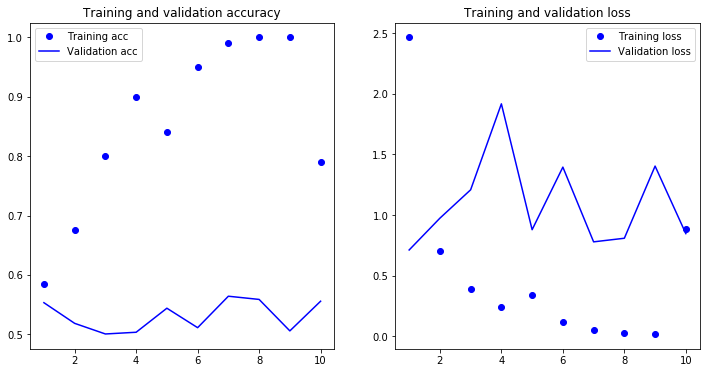

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(122)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

模型很快就开始过拟合，考虑到训练样本很少，这一点也不奇怪。出于同样的原因，验证精度的波动很大，但似乎达到了接近`60%`。

**注意**，你的结果可能会有所不同。训练样本数太少，所以模型性能严重依赖于你选择的 200 个样本，而样本是随机选择的。如果你得到的结果很差，可以尝试重新选择200个不同的随机样本，你可以将其作为练习（在现实生活中无法选择自己的训练数据）。

你也可以在不加载预训练词嵌入、也不冻结嵌入层的情况下训练相同的模型。在这种情况下，你将会学到针对任务的输入标记的嵌入。如果有大量的可用数据，这种方法通常比预训练词嵌入更加强大，但本例只有200个训练样本。我们来试一下这种方法。

In [19]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 3ms/step - loss: 0.6864 - acc: 0.6100 - val_loss: 0.6928 - val_acc: 0.5165
Epoch 2/10
200/200 [==============================] - 0s 2ms/s

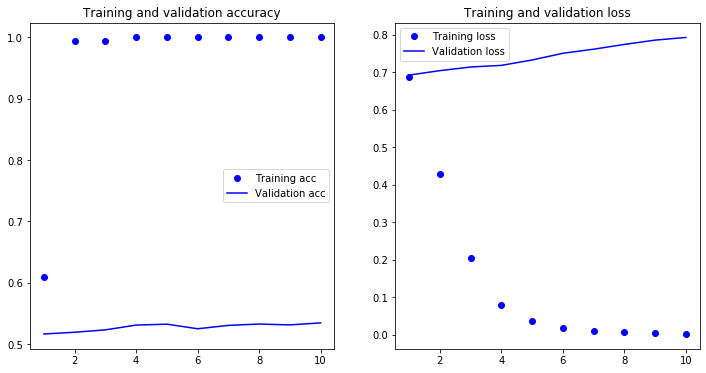

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(122)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

验证精度停留在`50%`多一点。因此，在本例中，预训练词嵌入的性能要优于与任务一起学习的嵌入。如果增加样本数量，情况将很快发生变化，你可以把它作为一个练习。

最后，我们在测试数据上评估模型。首先，你需要对测试数据进行分词。

In [23]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

接下来，加载并评估第一个模型。

In [25]:
model.load_weights('./model/pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 32us/step


[0.8635557767105102, 0.5460000038146973]

测试精度只有`56%` ！处理小数据集可见是非常困难的事情。

### 6.1.4 小结
现在你已经学会了下列内容：
+ 将原始文本转换为神经网络能够处理的格式
+ 使用`Keras`模型的`Embedding`层来学习针对特定任务的标记嵌入
+ 使用预训练词嵌入在小型自然语言处理问题上获得额外的性能提升